## Using Keras to Build and Train Neural Networks

In this exercise I will use a neural network to predict diabetes using the Pima Diabetes Dataset.  I will start by training a Random Forest to get a performance baseline.  Then I will use the Keras package to quickly build and train a neural network and compare the performance.  I will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* I've been using this dataset[UCI ML Repositiory](http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) for work

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [11]:
 names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/diabetes.csv', names = names, header=0)

In [12]:
print(diabetes_df.shape)
diabetes_df.head()

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [13]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [14]:
# Split the data to Train, and Test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11111)

In [15]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Baseline performance using Random Forest

In [16]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.766
roc-auc is 0.829


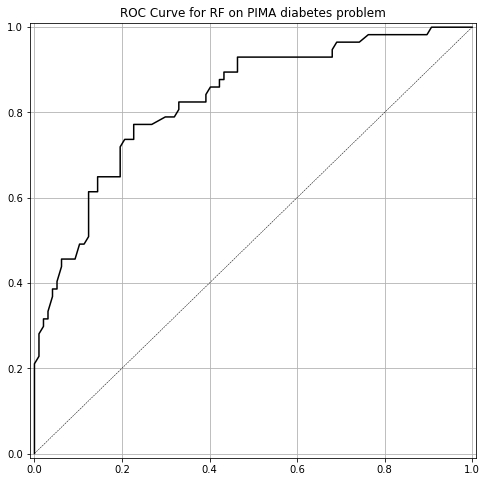

In [19]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [20]:
## First let's normalize the data to provide numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [21]:
# Define the Model

model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))

In [22]:
#Summary

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?

Let's fit our model for 200 epochs.

In [23]:
# Fit(Train)

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)

Epoch 1/200
20/20 [==============================] - 0s 8ms/step - loss: 1.0364 - accuracy: 0.3436 - val_loss: 0.9668 - val_accuracy: 0.3701
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9955 - accuracy: 0.3436 - val_loss: 0.9302 - val_accuracy: 0.3701
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9572 - accuracy: 0.3436 - val_loss: 0.8992 - val_accuracy: 0.3701
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9246 - accuracy: 0.3436 - val_loss: 0.8704 - val_accuracy: 0.3701
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8943 - accuracy: 0.3436 - val_loss: 0.8443 - val_accuracy: 0.3701
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8667 - accuracy: 0.3436 - val_loss: 0.8212 - val_accuracy: 0.3701
Epoch 7/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8421 - accuracy: 0.3420 - val_loss: 0.8001 - val_accuracy: 0.3636
Epoch 8/200
2

In [24]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [26]:
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

In [27]:
y_pred_prob_nn_1[:10]

array([[0.34950876],
       [0.5139223 ],
       [0.28145432],
       [0.38045368],
       [0.24231207],
       [0.44820568],
       [0.2211746 ],
       [0.3719083 ],
       [0.53478384],
       [0.40735883]], dtype=float32)

accuracy is 0.747
roc-auc is 0.776


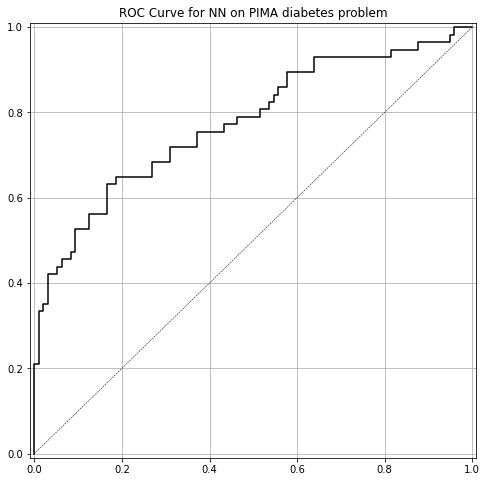

In [28]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [29]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

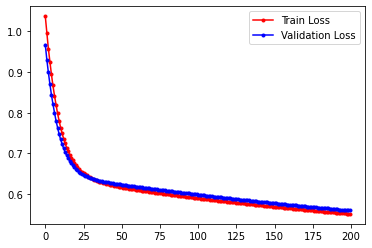

In [30]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [31]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.5516 - accuracy: 0.7215 - val_loss: 0.5603 - val_accuracy: 0.7468
Epoch 2/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.7231 - val_loss: 0.5599 - val_accuracy: 0.7468
Epoch 3/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5509 - accuracy: 0.7231 - val_loss: 0.5596 - val_accuracy: 0.7468
Epoch 4/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5506 - accuracy: 0.7231 - val_loss: 0.5594 - val_accuracy: 0.7468
Epoch 5/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5503 - accuracy: 0.7248 - val_loss: 0.5590 - val_accuracy: 0.7532
Epoch 6/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5500 - accuracy: 0.7264 - val_loss: 0.5587 - val_accuracy: 0.7532
Epoch 7/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5496 - accuracy: 0.7264 - val_loss: 0.5584 - val_accuracy: 0.7532
Epoch 

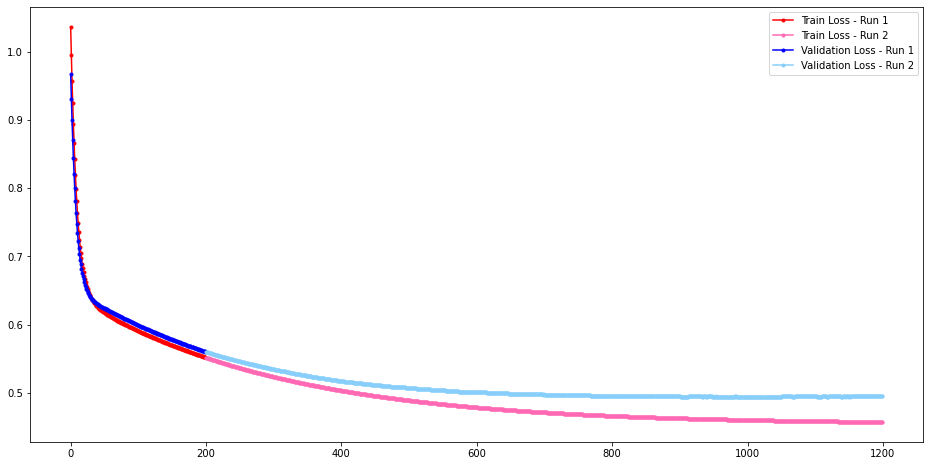

In [32]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

This graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized.  This suggests that our network will not benefit from further training.

In [33]:
### BEGIN SOLUTION
model_2 = Sequential()
model_2.add(Dense(6, input_shape=(8,), activation="relu"))
model_2.add(Dense(6,  activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Epoch 1/1500
20/20 [==============================] - 0s 15ms/step - loss: 1.1141 - accuracy: 0.3518 - val_loss: 1.0919 - val_accuracy: 0.3117
Epoch 2/1500
20/20 [==============================] - 0s 2ms/step - loss: 1.0540 - accuracy: 0.3616 - val_loss: 1.0347 - val_accuracy: 0.3117
Epoch 3/1500
20/20 [==============================] - 0s 2ms/step - loss: 1.0030 - accuracy: 0.3681 - val_loss: 0.9849 - val_accuracy: 0.3312
Epoch 4/1500
20/20 [==============================] - 0s 2ms/step - loss: 0.9587 - accuracy: 0.3811 - val_loss: 0.9450 - val_accuracy: 0.3377
Epoch 5/1500
20/20 [==============================] - 0s 2ms/step - loss: 0.9229 - accuracy: 0.4072 - val_loss: 0.9106 - val_accuracy: 0.3442
Epoch 6/1500
20/20 [==============================] - 0s 2ms/step - loss: 0.8919 - accuracy: 0.4088 - val_loss: 0.8822 - val_accuracy: 0.3636
Epoch 7/1500
20/20 [==============================] - 0s 2ms/step - loss: 0.8658 - accuracy: 0.4365 - val_loss: 0.8576 - val_accuracy: 0.3766
Epoch

In [34]:
run_hist_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

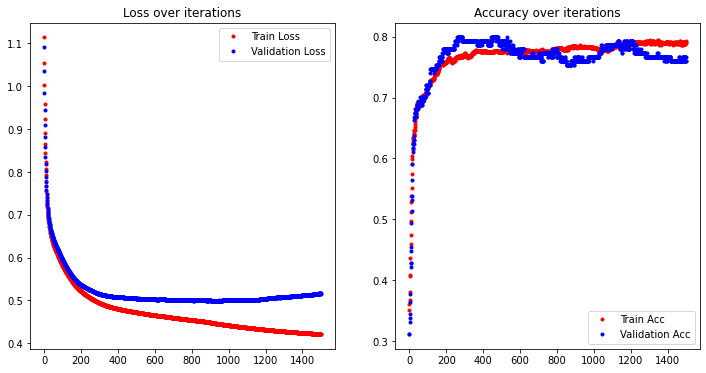

In [35]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')


accuracy is 0.766
roc-auc is 0.815


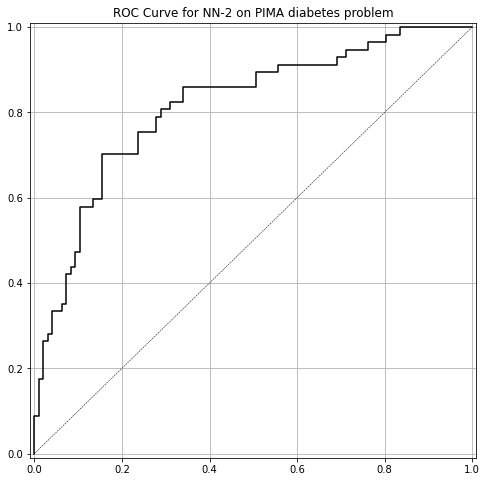

In [36]:
y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')
### END SOLUTION

- We can see that we didn't gain in terms of AUC and accuracy with the neural network, in comparison with the random Forest. 
This is very insightful, since it let us remember that sometimes, easiest model can do the same job, and even neural networks allows great performances on complex model, they're not necessarly the most adequate for easiest ones.